In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook, we calculate the `Percent Matching` score between chemical and genetic perturbations. The following are the steps taken
1. Normalized, feature selected ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe, for each time point and cell line.
2. All the target annotations of the compounds are used in this analysis.
3. Negative control and empty wells are removed from the dataframe.
4. The signal distribution, which is the median pairwise correlation between each Compound-CRISPR or Compound-ORF pair (that target the same gene), is computed.
5. The null distribution, which is the median pairwise correlation of Compound-CRISPRs or Compound-ORF that target different genes, is computed for 1000 combinations of Compound-CRISPRs or Compound-ORFs.
6. Percent Matching is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution
7. The signal and noise distributions and the Percent Matching values are plotted and the table of Percent Matching is printed.

In [2]:
n_samples = 5000

corr_df = pd.DataFrame()
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                # .rename(columns={'Metadata_target':'Metadata_gene'})
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        modality_1_df = (
            modality_1_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
            .assign(Metadata_gene=lambda x: x.Metadata_target_list.str.split('|'))
            .assign(Metadata_gene_list=lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_gene')
            .reset_index(drop=True)
        )

        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)

        both_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in both_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = both_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')
                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_gene_list=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_1_df, data_df)

                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                signal = utils.correlation_between_modalities(modality_1_df, modality_2_df, modality_1_perturbation, modality_2_perturbation,'Metadata_gene', 'Metadata_broad_sample')
                null = utils.null_correlation_between_modalities_list(modality_1_df, modality_2_df, modality_1_perturbation, modality_2_perturbation,'Metadata_gene', 'Metadata_broad_sample', n_samples)

                prop_95, value_95 = utils.percent_score(null, signal, how='right')

                corr_df = corr_df.append({'Description':f'{modality_1_perturbation}_{cell}_{modality_1_timepoint} vs. {modality_2_perturbation}_{cell}_{modality_2_timepoint}',
                                          'Matching':signal,
                                          'Null_Matching':null,
                                          'Percent_Matching':'%.1f'%prop_95,
                                          'Value_95':value_95}, ignore_index=True)

In [4]:
print(corr_df[['Description', 'Percent_Matching']].to_markdown(index=False))

| Description                          |   Percent_Matching |
|:-------------------------------------|-------------------:|
| compound_A549_24 vs. crispr_A549_144 |                7.7 |
| compound_A549_24 vs. crispr_A549_96  |                7.8 |
| compound_A549_24 vs. orf_A549_96     |                9   |
| compound_A549_24 vs. orf_A549_48     |                6.7 |
| compound_A549_48 vs. crispr_A549_144 |                7.8 |
| compound_A549_48 vs. crispr_A549_96  |                8.3 |
| compound_A549_48 vs. orf_A549_96     |                6.9 |
| compound_A549_48 vs. orf_A549_48     |                5.8 |
| compound_U2OS_24 vs. crispr_U2OS_144 |               11.2 |
| compound_U2OS_24 vs. crispr_U2OS_96  |                7.1 |
| compound_U2OS_24 vs. orf_U2OS_48     |                9.2 |
| compound_U2OS_24 vs. orf_U2OS_96     |                9.4 |
| compound_U2OS_48 vs. crispr_U2OS_144 |               10   |
| compound_U2OS_48 vs. crispr_U2OS_96  |                9.6 |
| compou

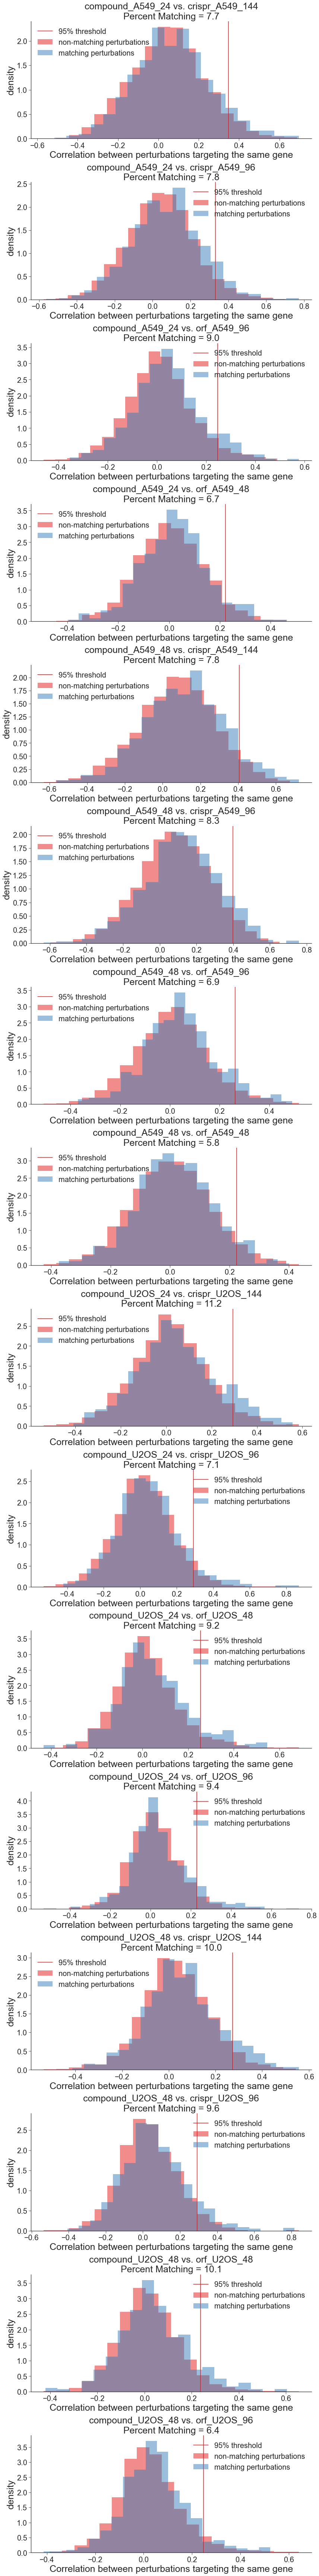

In [5]:
utils.distribution_plot(df=corr_df, output_file="9.percent_matching_compounds_vs_genes.png", metric="Percent Matching")

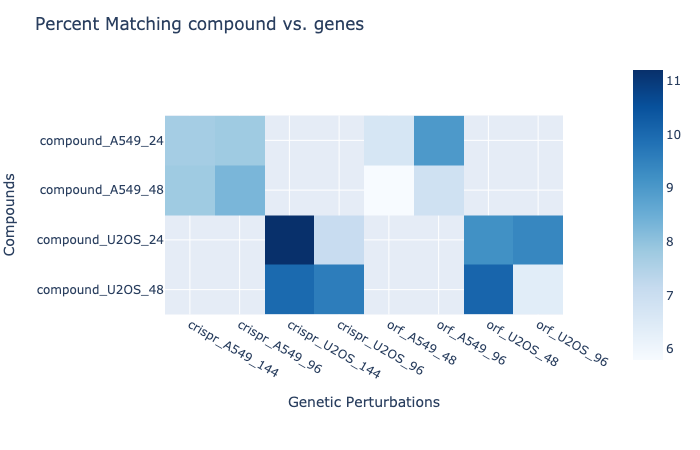

In [6]:
corr_df[['Chemical_Perturbation','Genetic_Perturbation']] = corr_df.Description.str.split(' vs. ', expand=True,)
corr_df['Percent_Matching'] = corr_df['Percent_Matching'].astype(float)
pivot_table = corr_df.pivot('Chemical_Perturbation','Genetic_Perturbation','Percent_Matching')
fig = px.imshow(pivot_table, color_continuous_scale='blues')
fig.update_layout(title='Percent Matching compound vs. genes',
                  xaxis=dict(title='Genetic Perturbations'),
                  yaxis=dict(title='Compounds'),
                  coloraxis_colorbar_x=+1.15)
fig.show("png")
fig.write_image(f'figures/9.percent_matching_heatmap.png', width=640, height=480, scale=2)

In [7]:
print(corr_df[['Chemical_Perturbation','Genetic_Perturbation','Percent_Matching']].to_markdown(index=False))

| Chemical_Perturbation   | Genetic_Perturbation   |   Percent_Matching |
|:------------------------|:-----------------------|-------------------:|
| compound_A549_24        | crispr_A549_144        |                7.7 |
| compound_A549_24        | crispr_A549_96         |                7.8 |
| compound_A549_24        | orf_A549_96            |                9   |
| compound_A549_24        | orf_A549_48            |                6.7 |
| compound_A549_48        | crispr_A549_144        |                7.8 |
| compound_A549_48        | crispr_A549_96         |                8.3 |
| compound_A549_48        | orf_A549_96            |                6.9 |
| compound_A549_48        | orf_A549_48            |                5.8 |
| compound_U2OS_24        | crispr_U2OS_144        |               11.2 |
| compound_U2OS_24        | crispr_U2OS_96         |                7.1 |
| compound_U2OS_24        | orf_U2OS_48            |                9.2 |
| compound_U2OS_24        | orf_U2OS_9